In [20]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
import tensorflow as tf
import pickle
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline

In [27]:
# Import glm_class.py as a module called glm
import glm_class as glm
     

In [28]:
behavior = scipy.io.loadmat('behav_big_matrix.mat')
behavior = behavior['behav_big_matrix']

behav_big_matrix_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')
behav_big_matrix_ids = behav_big_matrix_ids['behav_big_matrix_ids']

array_trial_ids = scipy.io.loadmat('array_trial_ids.mat')
array_trial_ids = array_trial_ids['array_trial_ids']

neural_data = scipy.io.loadmat('combined_response.mat')
neural_data = neural_data['combined_response']

In [29]:
# Check shape of neural activity (deconvolved)
neural_data.shape
print('Number of timepoints =', neural_data.shape[1], '\nNumber of neurons =', neural_data.shape[0])

Number of timepoints = 33192 
Number of neurons = 38


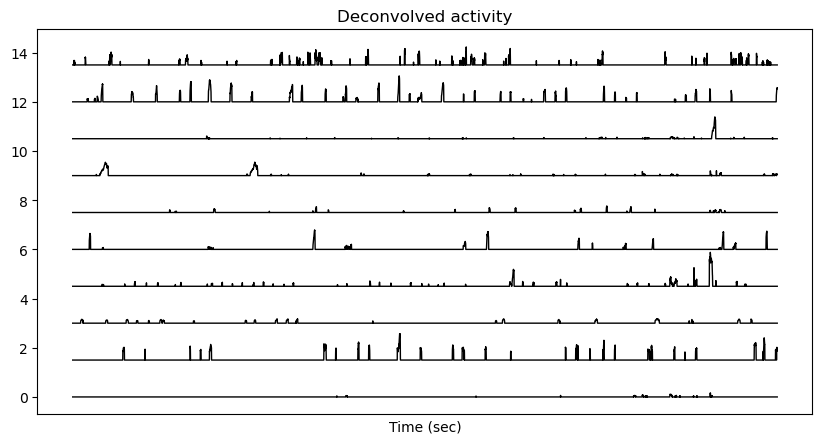

In [30]:
# Show deconvolved activity of the first 10 neurons

sampling_freq_hz = 15  # 15 Hz
start_timepoint = 0
end_timepoint = 10000

fig, axs = plt.subplots(1,1,figsize=(10,5))
neural_data_for_plot = neural_data.T
n_selected_neurons = 10
axs.plot(neural_data_for_plot[start_timepoint:end_timepoint,:n_selected_neurons] + 1.5 * np.arange(n_selected_neurons), 'k', linewidth=1)
axs.set_title('Deconvolved activity')
axs.set_xticks([])
axs.set_xlabel('Time (sec)');

In [31]:
cell_to_run_model_on = 4
neuron_for_model = neural_data[cell_to_run_model_on]
neuron_for_model

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
X = behavior.T
Y = neural_data.T
n_samples = X.shape[0]
group_id = array_trial_ids[0]
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.70, random_state = 42)
train_idx, test_idx = next(gss.split(X, Y, group_id))

# Split data into train and test set
X_train = X[train_idx,:]
Y_train = Y[train_idx]
X_test = X[test_idx,:]
Y_test = Y[test_idx]
trial_id_train = group_id[train_idx] # extract trial_id for training data, which is used in CV splits later during fitting
     


In [33]:
# Reset keras states
tf.keras.backend.clear_session()

# Initialize GLM_CV (here we're only specifying key input arguments; others are left as default values; see documentation for details)
model_cv = glm.GLM_CV(n_folds = 5, auto_split = True, split_by_group = True,
                      activation = 'exp', loss_type = 'poisson', 
                      regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(-1, -6, 11), 
                      optimizer = 'adam', learning_rate = 1e-2)

In [34]:
# Fit the GLM_CV on training data
model_cv.fit(X_train, Y_train, group_idx = trial_id_train, verbose = True) 

2023-08-22 08:01:25.729900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


n_fold = 0
Lambda 0 iter 100 loss: 0.20865291 diff: 0.00799451
Lambda 0 iter 200 loss: 0.17124400 diff: 0.00037357
Lambda 0 iter 300 loss: 0.14056197 diff: 0.00030648
Lambda 0 iter 400 loss: 0.11690626 diff: 0.00023621
Lambda 0 iter 500 loss: 0.09954765 diff: 0.00017329
Lambda 0 iter 600 loss: 0.08711449 diff: 0.00012411
Lambda 0 iter 700 loss: 0.07830209 diff: 0.00008796
Lambda 0 iter 800 loss: 0.07207299 diff: 0.00006218
Lambda 0 iter 900 loss: 0.06766133 diff: 0.00004404
Lambda 0 iter 1000 loss: 0.06452152 diff: 0.00003134
Lambda 0 iter 1100 loss: 0.06227164 diff: 0.00002246
Lambda 0 iter 1200 loss: 0.06064632 diff: 0.00001623
Lambda 0 iter 1300 loss: 0.05946159 diff: 0.00001183
Lambda 0 iter 1400 loss: 0.05858972 diff: 0.00000870
Lambda 0 iter 1500 loss: 0.05794183 diff: 0.00000647
Lambda 0 iter 1600 loss: 0.05745519 diff: 0.00000486
Lambda 0 iter 1700 loss: 0.05708634 diff: 0.00000368
Lambda 0 iter 1800 loss: 0.05680405 diff: 0.00000282
Lambda 0 iter 1900 loss: 0.05658609 diff: 0.

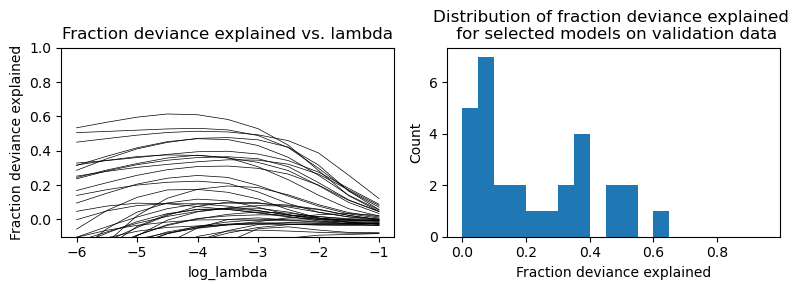

In [35]:
# Select models based on CV performance
model_cv.select_model(se_fraction = 0., min_lambda = 0., make_fig = True)

Fraction deviance explained: mean = 0.1147, median = 0.0830


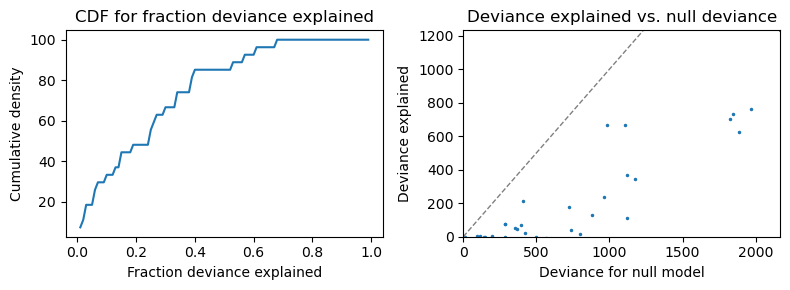

In [36]:
# Evaluate model performance on test data
frac_dev_expl, dev_model, dev_null, dev_expl = model_cv.evaluate(X_test, Y_test, make_fig = True)

In [37]:
# Make prediction on test data
y_pred = model_cv.predict(X_test)
print(y_pred.shape)

(10061, 38)


Fraction deviance explained = 0.60


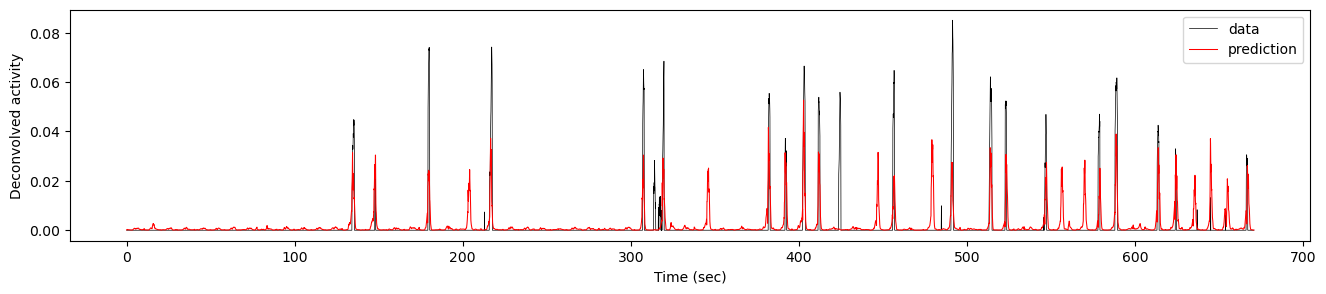

In [38]:
# Compare data and prediction for selected neuron
i_neuron = 4 # change this to examine different neurons
n_timepoints = y_pred.shape[0]
fig,ax = plt.subplots(figsize = (16,3))
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, Y_test[:n_timepoints, i_neuron]/10, 'k', lw = 0.5, label = 'data')
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, y_pred[:n_timepoints, i_neuron]/10, 'r', lw = 0.75, label = 'prediction')
plt.xlabel('Time (sec)')
plt.ylabel('Deconvolved activity')
plt.legend()
print(f'Fraction deviance explained = {frac_dev_expl[i_neuron]:.2f}')